# **목차**

- Random Search 알아보기
- Random Search 직접 해보기

  - 사용 데이터 셋 소개 및 EDA: 타이타닉
  - 직접 탐색 모델 구현하기
  - 라이브러리 사용하여 구현하기 (RandomizedSearchCV)
####2. Random Search 구현 및 데이터셋 소개
####3. RandomizedSearchCV의 파라미터
####4. RandomizedSearchCV의 메서드
####5. RandomizedSearchCV 활용

# **Random Search(랜덤 서치) 알아보기**

- Search Space에서 **특정 구간 내 랜덤 조합**으로 파라미터 값 선택  
    - **랜덤 조합의 수를 직접 설정**할 수 있기 때문에 불필요한 반복 탐색 감소  
    - 대표적인 Random Search 라이브러리: **RandomizedSearchCV**










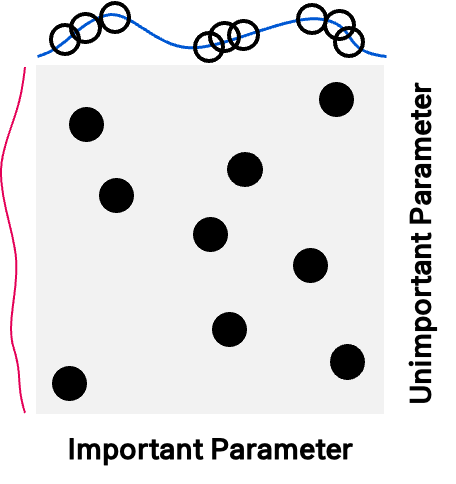

### Random search 알고리즘

하이퍼 파라미터 최적화 문제에서 Random Search는 주어진 하이퍼파라미터 셋에서 랜덤하게 파라미터를 선택 후 검증하는 방식으로, 이를 반복하여 최적 하이퍼파라미터를 찾아내게 됩니다.

그림으로 간단히 나타내면 아래와 같습니다.

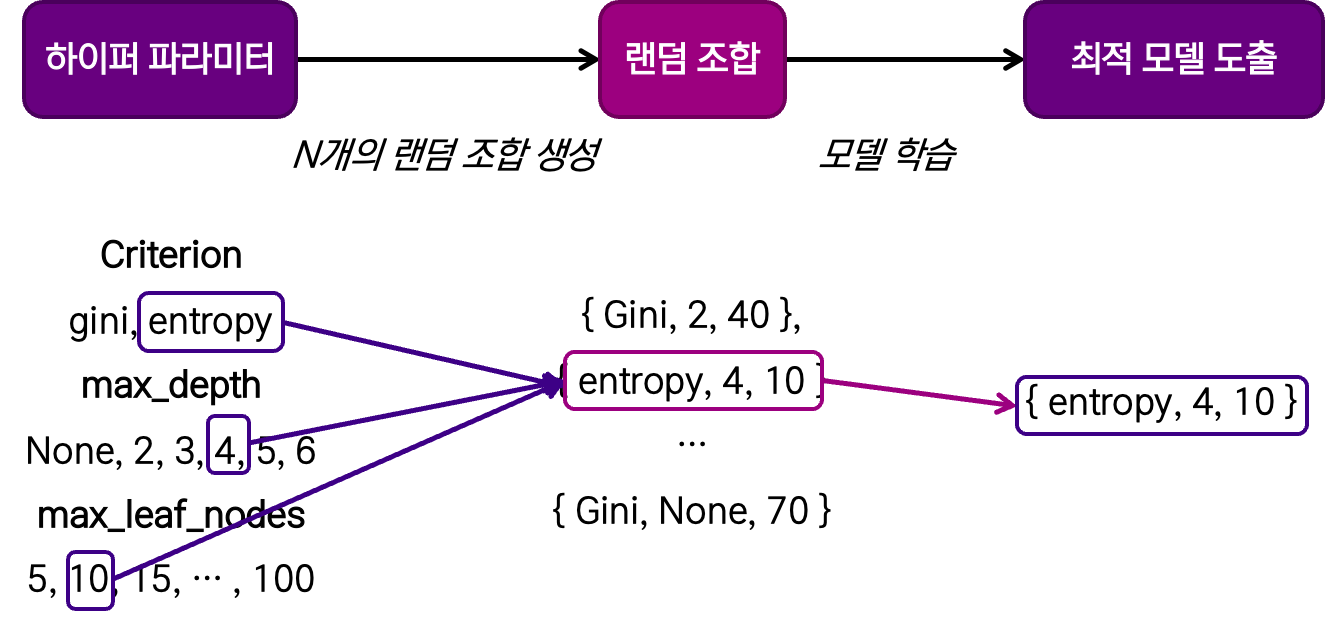

# **Random Search 직접 해보기**

sklearn의 모듈 RandomizedSearchCV를 활용하기 앞서 Random Search를 직접 구현해보겠습니다.

사용하려는 데이터셋은 **타이타닉 데이터셋**입니다.  
아래 사이트에서 데이터셋에 관한 설명과 다양한 분석 코드를 확인할 수 있습니다.  
[[재난] 타이타닉 : 누가 살아남았을까?](https://dacon.io/competitions/open/235539/overview/description)


## 1. 사용 데이터 셋 소개 및 EDA

 데이터셋에 관한 간단한 EDA입니다.  
- PassengerID : 탑승객 고유 아이디  
- Survival : 탑승객 생존 유무 (0: 사망, 1: 생존)
- Pclass : 등실의 등급
- Name : 이름
- Sex : 성별
- Age : 나이
- Sibsp : 함께 탐승한 형제자매, 아내, 남편의 수
- Parch : 함께 탐승한 부모, 자식의 수
- Ticket :티켓 번호
- Fare : 티켓의 요금
- Cabin : 객실번호
- Embarked : 배에 탑승한 항구 이름 ( C = Cherbourn, Q = Queenstown, S = Southampton)

In [1]:
## 데이터셋 불러오기 ##
#from google.colab import drive
#drive.mount('/content/drive') # 구글 드라이브를 사용하는 경우

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#train = pd.read_csv("/content/drive/MyDrive/데이크루2기_MAT/2주차_Data/titanic_train.csv") # 파일이 위치한 폴더
train = pd.read_csv('train.csv')
print("================데이터셋 크기================")
print(train.shape) # 891 샘플, 12 컬럼으로 구성된 데이터
print("================데이터셋 구조================")
print(train.info())
print("================데이터셋 샘플================")
train.head() # 데이터 샘플

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

### 예측값(Survived) 비율

================전체 생존률================
0    549
1    342
Name: Survived, dtype: int64


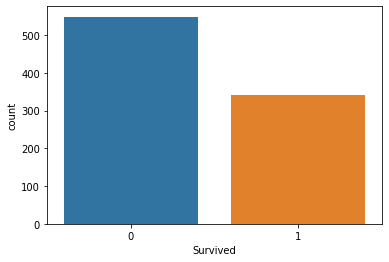

================탑승 항구에 따른 생존률================


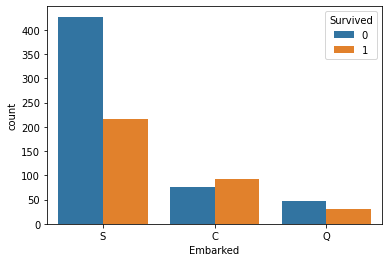

================성별에 따른 생존률================


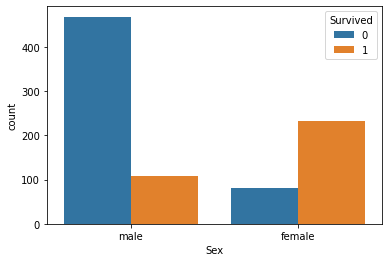

In [2]:
## 예측값(Survived) 비율 ##
print("================전체 생존률================")
print(train['Survived'].value_counts())
sns.countplot(x = 'Survived', data = train, order = train['Survived'].value_counts().index)
plt.show()
print("================탑승 항구에 따른 생존률================")
sns.countplot(x = 'Embarked', data = train, hue='Survived', order = train['Embarked'].value_counts().index)
plt.show()
print("================성별에 따른 생존률================")
sns.countplot(x = 'Sex', data = train, hue='Survived', order = train['Sex'].value_counts().index)
plt.show()

### 전처리
- 변수 선택
- 결측치 처리
- 카테고리 변수 인코딩
- train/test 셋 분리

In [3]:
## 예측에 불필요한 컬럼 삭제 및 데이터전처리 ##
train = train.drop(['PassengerId','Name','Ticket','Cabin'], axis=1) # 불필요한 컬럼 삭제

# Age의 결측값을 평균값으로 대체
age_avg = train[train['Age'] > 0]['Age'].mean()
train['Age'] = train['Age'].fillna(age_avg) 

# Embarked의 결측값을 최빈값으로 대체
embarked_mode = train['Embarked'].value_counts().index[0]
train['Embarked'] = train['Embarked'].fillna(embarked_mode)
train['Embarked'] = train['Embarked'].fillna(embarked_mode)

# 원핫인코딩
train = pd.get_dummies(train, columns = ['Sex', 'Embarked'])

# 훈련셋, 테스트셋 분리
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train.drop(['Survived'], axis=1), train['Survived'], test_size=0.3, random_state=555)

print("================데이터전처리 결과================")
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_train.head()

================데이터전처리 결과================
(623, 10) (623,) (268, 10) (268,)


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
738,3,29.699118,0,0,7.8958,0,1,0,0,1
2,3,26.000000,0,0,7.9250,1,0,0,0,1
635,2,28.000000,0,0,13.0000,1,0,0,0,1
26,3,29.699118,0,0,7.2250,0,1,1,0,0
293,3,24.000000,0,0,8.8500,1,0,0,0,1


## 2. 직접 탐색모델 구현하기
- 예측 모델: 의사결정 나무(Decision Tree)

In [4]:
from numpy import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 하이퍼 파라미터 목록
param_dict = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 2, 3, 4, 5, 6], 
    'max_leaf_nodes':range(5, 101, 5)
}

# Random Search 수행
## 랜덤 파라미터 추출 
def random_param_list(param_dict, n_iter=10, random_state=0):
    random_result = []
    for i in range(n_iter):
        choice_list = []
        for dic in param_dict.keys():
            random.seed(random_state+i)
            choice_list.append(random.choice(param_dict[dic]))
        random_result.append(choice_list)
    return random_result

print("================랜덤 하이퍼 파라미터 리스트================")
param_list = random_param_list(param_dict, n_iter=10, random_state=555)
print(param_list)

## 랜덤 파라미터 모델 생성 및 학습
rm_result = []
for l in param_list:
    rm_model = DecisionTreeClassifier(criterion=l[0], max_depth=l[1], max_leaf_nodes=l[2], random_state = 555) # 모델 생성, 사용할 파라미터 직접 입력
    rm_model.fit(x_train, y_train) # 모델 학습

    # 모델 성능 평가 및 저장
    y_pred = rm_model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    rm_result.append([str(l), acc])

# 최적 하이퍼 파라미터 조합
print("================최적 하이퍼 파라미터 조합================")
rm_result_acc = list(np.array(rm_result)[:,1])
print(rm_result[rm_result_acc.index(max(rm_result_acc))])

# 하이퍼 파라미터 조합별 결과
print("================하이퍼 파라미터 조합별 결과================")
rm_param_result = pd.DataFrame(rm_result, columns=['params', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
rm_param_result

================랜덤 하이퍼 파라미터 리스트================
[['gini', 3, 75], ['entropy', 2, 80], ['gini', 3, 15], ['entropy', 2, 50], ['entropy', 4, 20], ['gini', 3, 55], ['entropy', 2, 90], ['entropy', 4, 60], ['gini', 4, 10], ['entropy', 2, 90]]
================최적 하이퍼 파라미터 조합================
["['gini', 4, 10]", 0.835820895522388]
================하이퍼 파라미터 조합별 결과================


,params,Accuracy
8,"['gini', 4, 10]",0.835821
0,"['gini', 3, 75]",0.832090
2,"['gini', 3, 15]",0.832090
5,"['gini', 3, 55]",0.832090
4,"['entropy', 4, 20]",0.824627
7,"['entropy', 4, 60]",0.824627
1,"['entropy', 2, 80]",0.813433
3,"['entropy', 2, 50]",0.813433
6,"['entropy', 2, 90]",0.813433
9,"['entropy', 2, 90]",0.813433


## 3. 라이브러리 사용하여 구현하기
### RandomizedSearchCV의 파라미터

> class sklearn.model_selection.RandomizedSearchCV(estimator, param_distributions, *, n_iter=10, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', random_state=None, error_score=nan, return_train_score=False)

- **estimator** : 모델 객체 지정
- **param_distributions** : 하이퍼 파라미터 목록을 딕셔너리로 전달
- **n_iter** : 하이퍼 파라미터 검색 횟수(10: 기본값)
- **scoring** : 성능 평가 지표('accuracy', 'f1', 'neg_mean_squared_error', 'r2')
- **n_jobs** : 사용할 CPU 코어 개수 (1: 기본값, -1: 모든 코어 다 사용)
- **refit** : 최적의 하이퍼 파라미터를 찾아서 estimator 재학습
- **cv** : 교차검증 시 fold 개수


> 구체적인 라이브러리 사용법  
    [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)




### RandomizedSearchCV의 메서드

- **RandomizedSearchCV객체.cv_results** : 하이퍼 파라미터 조합별 결과
- **RandomizedSearchCV객체.best_estimator_** : refit으로 학습된 최적 모델 
- **RandomizedSearchCV객체.best_score_** : 최고 평균 성능평가 점수
- **RandomizedSearchCV객체.best_params_** : 최적 하이퍼 파라미터 조합

### RandomizedSearchCV 적용




In [5]:
from sklearn.model_selection import RandomizedSearchCV

# 모델 생성
dt_model = DecisionTreeClassifier() 

# 하이퍼 파라미터 목록
dt_param = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 2, 3, 4, 5, 6], 
    'max_leaf_nodes':range(5, 101, 5)
}

# Random Search 수행
randomized_search = RandomizedSearchCV(dt_model, param_distributions=dt_param, n_iter=10, return_train_score=True, random_state=555)
randomized_search.fit(x_train, y_train)

# 최적 하이퍼 파라미터 조합
print("================최적 하이퍼 파라미터 조합================")
print(randomized_search.best_params_)

# 하이퍼 파라미터 조합별 결과
print("================하이퍼 파라미터 조합별 결과================")
df_param_distributions = pd.DataFrame(randomized_search.cv_results_).sort_values(by=['mean_test_score', 'mean_train_score'], ascending=False)
df_param_distributions[['params', 'mean_train_score', 'mean_test_score']]  

================최적 하이퍼 파라미터 조합================
{'max_leaf_nodes': 20, 'max_depth': None, 'criterion': 'entropy'}
================하이퍼 파라미터 조합별 결과================


,params,mean_train_score,mean_test_score
7,"{'max_leaf_nodes': 20, 'max_depth': None, 'cri...",0.860354,0.834645
6,"{'max_leaf_nodes': 55, 'max_depth': 3, 'criter...",0.821428,0.812168
1,"{'max_leaf_nodes': 55, 'max_depth': 3, 'criter...",0.818216,0.810568
4,"{'max_leaf_nodes': 40, 'max_depth': 3, 'criter...",0.818216,0.810568
5,"{'max_leaf_nodes': 80, 'max_depth': 3, 'criter...",0.818216,0.810568
0,"{'max_leaf_nodes': 15, 'max_depth': 5, 'criter...",0.847511,0.808981
3,"{'max_leaf_nodes': 90, 'max_depth': 5, 'criter...",0.843902,0.804142
8,"{'max_leaf_nodes': 60, 'max_depth': 5, 'criter...",0.843902,0.804142
2,"{'max_leaf_nodes': 65, 'max_depth': 5, 'criter...",0.844303,0.800916
9,"{'max_leaf_nodes': 60, 'max_depth': 4, 'criter...",0.830252,0.797781


---

본 글에서는 Random Search를 소개하며, 이를 직접 구현해보고, 상용화된 라이브러리도 사용해보았습니다. 이 때, 사용한 데이터는 `titanic data set`이고, 모델은 `random forest`입니다.

간단하게 search space를 탐색할 수 있는 방법 중 하나인 random search는 쉽게 사용할 수 있지만, 최적값을 찾는데는 한계가 있습니다.

다음 글에서는 목적함수에 대한 통계값을 활용한 방법인 `Bayesian Search`에 대해 알아보겠습니다.

이번 글도 읽어주셔 감사합니다 :)
